# Figure 1
Build figure 1 with three panels:\
(A) - Distribution of contig sizes by short read vs long read\
(B) - Replicon mosaicism shown by Sankey\
(C) - Plasmid correspondence tree

In [1]:
import pandas as pd
import numpy as np
import json
import re
from collections import Counter
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib import gridspec
from matplotlib.path import Path
from matplotlib.patches import Patch, PathPatch
import colorcet as cc

import warnings
warnings.filterwarnings('ignore')

## Read in data

In [2]:
def calc_entropy(x):
    frequency = Counter(x)
    total_count = sum(frequency.values())
    pk = [count / total_count for string, count in frequency.items()]
    return stats.entropy(pk)

In [7]:
best_matches

,assembly_id,contig_id,contig_len,plasmid_id,plasmid_name,strain,query_length,ref_length,overall_percent_identity,query_covered_length,ref_covered_length,covered_intervals,query_intervals,subject_hit_coords,query_coverage_percent,call_method
0,B331P,contig_1 [gcode=11] [topology=linear],903654,B500_chromosome_ParA_2,chromosome,B500,903654,380,100.0,1091,363,"[(1, 364)]","[(368951, 370042)]","[(1, 364)]",0.120732,pf32
1,B331P,contig_10 [gcode=11] [topology=linear],8714,gb|CP017210.1|,cp9,B331,8714,8714,100.0,8713,8713,"[(1, 8714)]","[(1, 8714)]","[(1, 8714)]",99.988524,wp
2,B331P,contig_11 [gcode=11] [topology=linear],15594,RS00875_MM1_plsm_lp17_ParA_X,lp17,RS00875,15594,246,100.0,725,241,"[(1, 242)]","[(12036, 12761)]","[(1, 242)]",4.649224,pf32
3,B331P,contig_12 [gcode=11] [topology=linear],24722,RS00040_ZS7_ZS7_lp25_ParA_X,lp25,RS00040,24722,252,100.0,755,251,"[(1, 252)]","[(11900, 12655)]","[(1, 252)]",3.053960,pf32
4,B331P,contig_13 [gcode=11] [topology=linear],27641,H28_B31_lp28-3_ParA_X,lp28-3,H28,27641,251,100.0,752,250,"[(1, 251)]","[(16701, 17453)]","[(1, 251)]",2.720596,pf32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,XYZ459H,contig_5 [gcode=11] [topology=linear],30073,RS01730_MM1_plsm_cp32-9_ParA_X,cp32-9,RS01730,30073,251,100.0,743,247,"[(1, 248)]","[(862, 1605)]","[(1, 248)]",2.470655,pf32
1681,XYZ459H,contig_6 [gcode=11] [topology=linear],29839,RS05185_N40_N40_lp28-2_ParA_X,lp28-2,RS05185,29839,255,100.0,764,254,"[(1, 255)]","[(23086, 23850)]","[(1, 255)]",2.560408,pf32
1682,XYZ459H,contig_7 [gcode=11] [topology=linear],29476,I21_B31_lp28-4_ParA_X,lp28-4,I21,29476,250,100.0,749,249,"[(1, 250)]","[(14038, 14787)]","[(1, 250)]",2.541050,pf32
1683,XYZ459H,contig_8 [gcode=11] [topology=linear],28681,A20_B31_lp54_ParA_X,lp54,A20,28681,250,100.0,749,249,"[(1, 250)]","[(14294, 15043)]","[(1, 250)]",2.611485,pf32


In [10]:
best_matches['contig_id'][0]

'contig_1 [gcode=11] [topology=linear]'

In [52]:
best_matches = pd.read_csv('../results/best_hits_1000bp_v10.2.csv')
best_matches = pd.read_csv('../results/best_hits_1000bp_v10.2.csv')
best_matches['best_hit'] = best_matches['plasmid_name']
best_matches['name'] = best_matches['assembly_id']
best_matches['best_hit'] = best_matches['best_hit'].fillna('Unannotated')
best_matches = best_matches[best_matches['best_hit']!='Unannotated']
best_matches['contig'] = best_matches['contig_id'].apply(lambda x: x.split(' ')[0])
longread_best_matches = best_matches[['name', 'contig', 'contig_len', 'best_hit']]

# Genes
import os
align_parent = '../alignments/B31/prot/'
genes = pd.DataFrame()
for d in os.listdir(align_parent):
    genes = pd.concat([genes,
                       pd.read_csv(align_parent+d+'/align_coords.tsv', sep='\t')])
# genes = pd.read_csv('../results/gene_synteny_v4.tsv', sep='\t')
genes = pd.merge(genes, longread_best_matches, left_on=['QUERY_ID', 'QUERY_NAME'], right_on=['name', 'contig']).drop(columns=['name', 'contig']).rename(columns={'best_hit':'Canon replicon'})
replicon_id_dict = {rep:i for i, rep in enumerate(set(genes['REF_NAME'].values.tolist() + genes['Canon replicon'].values.tolist()))}
query_entropy = genes[['REF_NAME', 'Canon replicon']].groupby('REF_NAME').agg(lambda x: calc_entropy(x)).reset_index().rename(columns={'Canon replicon':'REF_NAME entropy'})
ref_entropy = genes[['REF_NAME', 'Canon replicon']].groupby('Canon replicon').agg(lambda x: calc_entropy(x)).reset_index().rename(columns={'REF_NAME':'Canon replicon entropy'})
genes = pd.merge(genes, query_entropy, on='REF_NAME')
genes = pd.merge(genes, ref_entropy, on='Canon replicon')

# Sankey
genes_sankey = genes[['REF_NAME', 'Canon replicon', 'REF_NAME entropy', 'Canon replicon entropy', 'IDENTITY']
                    ].groupby(['REF_NAME', 'Canon replicon', 'REF_NAME entropy', 'Canon replicon entropy']
                    ).agg('sum').reset_index()

genes_sankey = genes_sankey.sort_values(by='REF_NAME entropy').reset_index(drop=True)

## Functions

### (A)

In [25]:
def custom_sort_key(s):
    # Use regular expressions to extract the numeric parts
    match = re.match(r'[a-zA-Z]+(\d+)(?:-[a-zA-Z]*(\d+))?', s)
    if match:
        first_number = int(match.group(1))
        second_number = int(match.group(2)) if match.group(2) else 0
        return (first_number, second_number)
    return (0, 0)

def sort_replicons(replicons):
    # Group replicons by type
    cps = []; lps = []; chrom = []; fusions = []; nans=[];
    for rep in replicons:
        if 'cp' in rep and 'lp' in rep:
            fusions.append(rep)
        elif 'cp' in rep:
            cps.append(rep)
        elif 'lp' in rep:
            lps.append(rep)
        elif 'chrom' in rep:
            chrom.append(rep)
        else:
            nans = ['Unannotated']
            
    # Sort replicons within type
    cps = sorted(cps, key=custom_sort_key)
    lps = sorted(lps, key=custom_sort_key)
    fusions = sorted(fusions, key=custom_sort_key)
    
    # Get x values
    buffer = 2
    order = [nans, cps, lps, fusions, chrom] if nans!= [] else [cps, lps, fusions, chrom]
    xvals = []
    ordered_replicons = []
    for i, s in enumerate(order):
        ordered_replicons += s
        xvals += [x+len(xvals)+i*buffer for x in range(len(s))]
        
    return ordered_replicons, xvals
# 

### (B)

In [26]:
def mean_weight(df, init_weight, geomean=False):
    m = df[init_weight].mean()
    df['weight'] = df[init_weight].apply(lambda x: (x+m)/2)
    if geomean:
        df['weight'] = df[init_weight].apply(lambda x: np.sqrt(x*m))
    return df

In [27]:
# Steps to plot Sankey:
    # 1. Get y coordinates of s1
    #     a. Need to know height of each bar in s1
    # 2. Get y coordinates of s2
    #     a. Need to know height of each bar in s2
    # 3. For each row in df, draw a bar:
    #     a. Get y_left_start, y_left_end
    #         i. Start coord is ycoord of element plus heights of other shaded regions
    #     b. Get y_right_start, y_right_end
    #         i. Start coord is ycoord of element plus heights of other shaded regions
    #     c. Draw and shade curves - probably easiest to use convolution
    
def setup(tup):
    fig, ax = tup
    ax.set_axis_off()
    ax.set_xlim([-0.01, 1.1])
    return fig, ax

def create_color_dict(df, left, right):
    with open('../reference/plasmid_color_dict.json', 'r') as f:
        colorDict = json.load(f)
    all_replicons = set(df[left].values.tolist()).union(set(df[right].values.tolist()))
    colorDict = {rep:cc.glasbey[i] if rep not in colorDict.keys() else colorDict[rep] for i, rep in enumerate(all_replicons)}
    return colorDict
    
def calc_heights(df, var, weight, order, buffer=None):
    if not buffer:
        buffer = df[weight].mean()
    
    df = df[[var, weight, order]].groupby(var).agg({weight:'sum', order:'mean'})
    df = df.sort_values(by=order)
    df['weight_plus_buffer'] = df[weight] + buffer
    df['y_start'] = df['weight_plus_buffer'].cumsum().shift(1, fill_value=0)
    df['y_end'] = df['y_start'] + df[weight]
    df = df.drop(columns='weight_plus_buffer')
    return df

def calc_heights_with_blocking(df, var, weight, order, buffer=None):
    def get_replicon_type(x):
        if x=='chromosome':
            return 'A'#'chromosome'
        elif 'lp' in x and 'cp' in x:
            return 'D'#'fusion plasmid'
        elif 'lp' in x:
            return 'B'#'linear plasmid'
        elif 'cp' in x:
            return 'C'#'circular plasmid'

    if not buffer:
        buffer = df[weight].mean()
    df = df[[var, weight, order]].groupby(var).agg('sum').reset_index()
    df['replicon type'] = df[var].apply(lambda x: get_replicon_type(x))
    df = df.sort_values(by=['replicon type', order]).reset_index(drop=True)
    df['weight_plus_buffer'] = df[weight] + buffer

    # Add space when starting a new replicon type
    rep_type = df.iloc[0]['replicon type']
    for idx, row in df.iterrows():
        if rep_type != row['replicon type']:
            # New replicon type
            df.at[idx-1, 'weight_plus_buffer'] += buffer*10
            rep_type = row['replicon type']
    
    df['y_start'] = df['weight_plus_buffer'].cumsum().shift(1, fill_value=0)
    df['y_end'] = df['y_start'] + df[weight]
    df = df.drop(columns='weight_plus_buffer')
    return df.set_index(var)

def ylabels(df, left, right, leftWeight, rightWeight, leftOrder, rightOrder, colorDict, ax, f=9):
    s1 = calc_heights_with_blocking(df, left, leftWeight, leftOrder)
    s2 = calc_heights_with_blocking(df, right, rightWeight, rightOrder)
    for idx, row in s1.iterrows():
        ax.vlines(0, row['y_start'], row['y_end'], linewidth=2, color=colorDict[idx])
        ax.text(-0.02, (row['y_start'] + row['y_end']) / 2, idx, fontsize=f, ha='right', va='center')
    for idx, row in s2.iterrows():
        ax.vlines(1, row['y_start'], row['y_end'], linewidth=2, color=colorDict[idx])
        ax.text(1.02, (row['y_start'] + row['y_end']) / 2, idx, fontsize=f, ha='left', va='center')
        
    return s1, s2

def draw_single_patch(y0L, y1L, y0R, y1R, color, ax):
    # Let y0L be the start y-coord on the left side and let y0R be the start y-coord on the right side
    # Let y1L be the end y-coord on the left side and let y1R be the end y-coord on the right side
    xL = 0.005   # Left x anchor
    xM = 0.5  # Mid x anchor
    xR = 0.995   # Right x anchor
    verts = [(xL,y1L), (xM,y1L), (xM,y1R), (xR,y1R), (xR,y0R), (xM,y0R), (xM,y0L), (xL,y0L), (xL,y1L)]  # length = 9
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, Path.CLOSEPOLY]  # length = 9
    p = Path(verts,codes)
    ax.add_patch(PathPatch(p, fc=color, ec='None', alpha=0.7))

def update_y_coords(rep, progress, height):
    y0 = progress[rep]
    y = [y0, y0+height]
    progress[rep] += height
    return rep, y
    
def draw_sankey_patches(df, s1, s2, left, right, leftWeight, rightWeight, colorDict, ax):
    yL = [0, 0]
    yR = [0, 0]
    repL = None
    repR = None
    progressL = dict(s1['y_start'])
    progressR = dict(s2['y_start'])
    for repL in s1.index:
        for repR in s2.index:
            row = df[(df[left]==repL) & (df[right]==repR)]
            if not row.empty:
                row = row.iloc[0]
                repL, yL = update_y_coords(row[left], progressL, row[leftWeight])
                repR, yR = update_y_coords(row[right], progressR, row[rightWeight])
                c = colorDict[repL]
                draw_single_patch(yL[0], yL[1], yR[0], yR[1], c, ax)

## Prepare data for plotting

In [55]:
############## A ##############
all_replicons = list(best_matches['best_hit'].unique())
# all_replicons.remove('Unannotated')
ordered_replicons, xvals = sort_replicons(all_replicons)
replicons_with_xpos = pd.DataFrame({'replicon':ordered_replicons, 'x_pos':xvals})
ordered_best_matches = pd.merge(best_matches, replicons_with_xpos, left_on='best_hit', right_on='replicon')


############## B ##############
left = 'REF_NAME'
right = 'Canon replicon'
init_weight = 'IDENTITY'
weight = 'weight'
left_order = 'REF_NAME entropy'
right_order = 'Canon replicon entropy'

df = genes_sankey.sort_values(by='REF_NAME entropy').reset_index(drop=True)
df = mean_weight(df, init_weight)

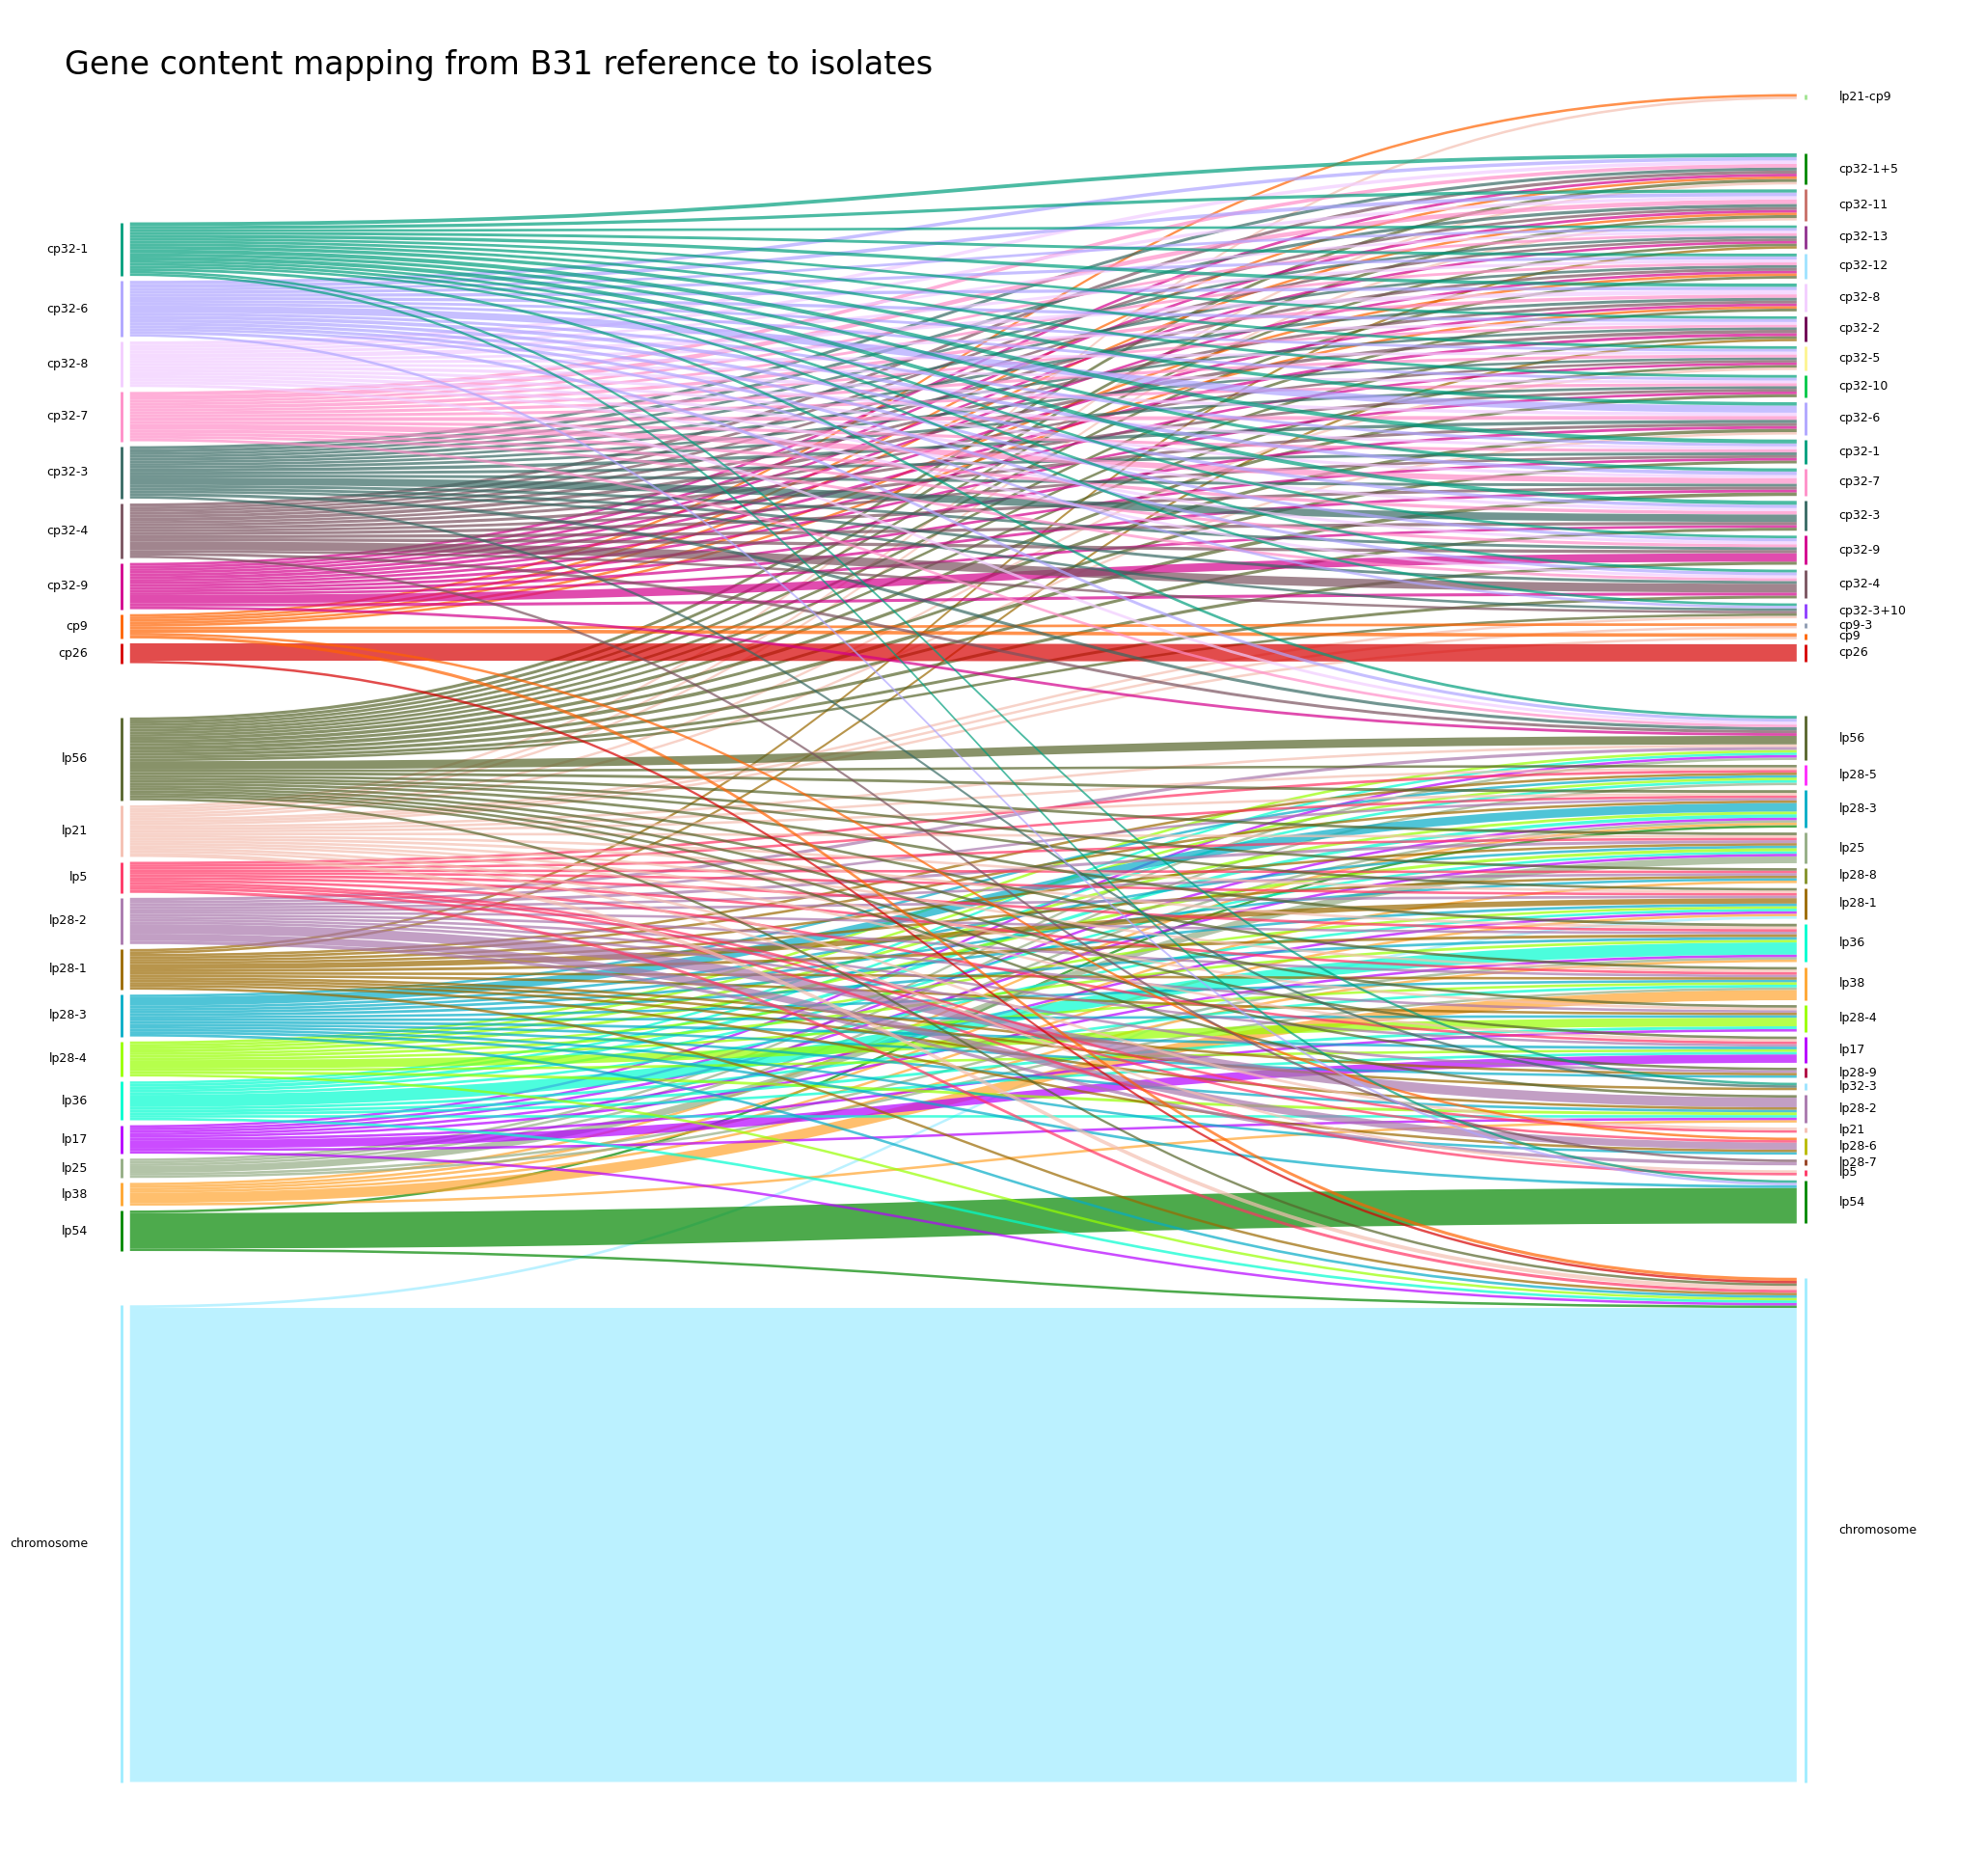

In [60]:
# Create a figure
fig, ax3 = plt.subplots(figsize=(25, 25))

# Define the grid with specific height and width ratios
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 4])

panel_label_fontsize=24

############## A ##############
ylim = [8e2, 1.1e6]

# Create bottom row subplot, left part
# ax3 = fig.add_subplot(gs[1, :])
# Add panel label
ax3.annotate('Gene content mapping from B31 reference to isolates', xy=(0, 0.94), xycoords='axes fraction', xytext=(-30, 30),
             fontsize=panel_label_fontsize, textcoords='offset points', ha='left', va='bottom',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

_, ax3 = setup((fig, ax3))
colorDict = create_color_dict(df, left, right)
s1, s2 = ylabels(df, left, right, weight, weight, left_order, right_order, colorDict, ax3)
draw_sankey_patches(df, s1, s2, left, right, weight, weight, colorDict, ax3)

plt.subplots_adjust(wspace=0, hspace=0.15)
fig.savefig('../paper/Fig1.pdf', format='pdf', dpi=100)

#### Most and least entropic replicons in reference and isolates

In [ ]:
# Most entropic reference replicons
genes_sankey[['QUERY_NAME', 'QUERY_NAME entropy']].drop_duplicates().sort_values(by='QUERY_NAME entropy', ascending=False).head(10)

In [ ]:
# Most entropic isolated replicons
genes_sankey[['Canon replicon', 'Canon replicon entropy']].drop_duplicates().sort_values(by='Canon replicon entropy', ascending=False).head(10)

In [ ]:
# Least entropic reference replicons
genes_sankey[['QUERY_NAME', 'QUERY_NAME entropy']].drop_duplicates().sort_values(by='QUERY_NAME entropy').head(10)

In [ ]:
# Least entropic isolated replicons
genes_sankey[['Canon replicon', 'Canon replicon entropy']].drop_duplicates().sort_values(by='Canon replicon entropy').head(10)

In [ ]:
genes_sankey

In [ ]:
genes_sankey[genes_sankey['Canon replicon']=='cp32-13']['QUERY_NAME'].sort_values()